In [3]:
#Import Libraries

import numpy as np                     # Numerical operations
import pandas as pd                    # Data handling
import matplotlib.pyplot as plt        # Plotting
import seaborn as sns                  # Better plots

# ML imports
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib                          # For saving/loading models

sns.set(style="whitegrid")             # Set nice plotting style


In [5]:
#LOAD DATASET

train = pd.read_csv("train.csv")  # Training data with target
test = pd.read_csv("test.csv")    # Test data without target

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()


Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


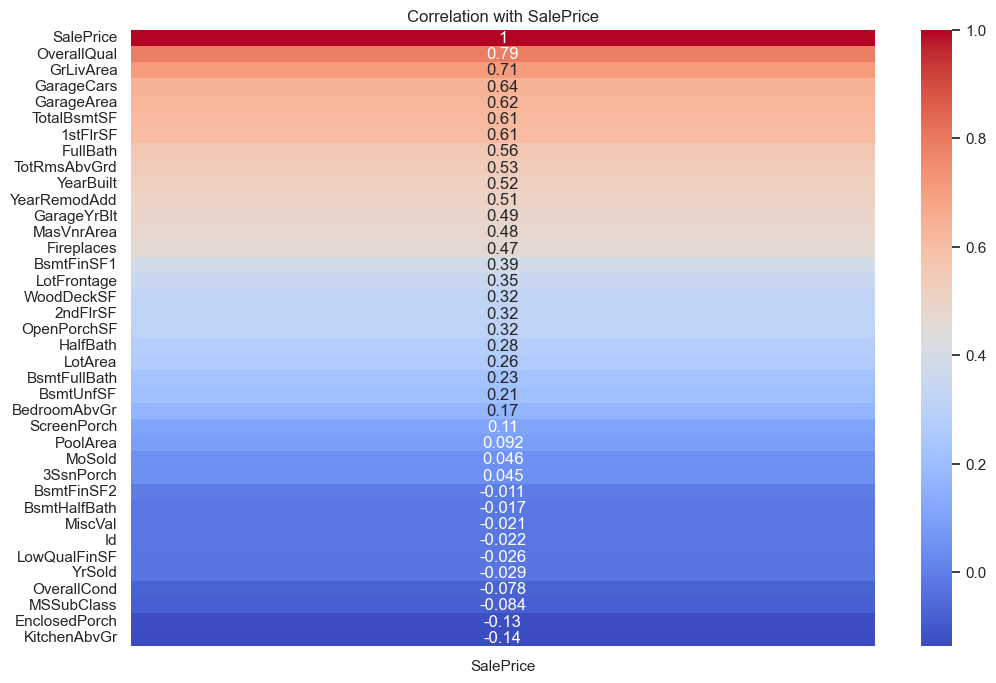

In [7]:
#EDA — Correlation Heatmap

# Keep numeric columns only
numeric_df = train.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(12,8))
sns.heatmap(corr[['SalePrice']].sort_values(by='SalePrice', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation with SalePrice")
plt.show()


In [9]:
# Baseline Model — Before Feature Engineering
X_base = train.drop(['SalePrice', 'Id'], axis=1)
y_base = train['SalePrice']

# Fill numeric NaNs with median
for col in X_base.select_dtypes(include=[np.number]).columns:
    X_base[col] = X_base[col].fillna(X_base[col].median())

# Fill categorical NaNs with mode
for col in X_base.select_dtypes(exclude=[np.number]).columns:
    X_base[col] = X_base[col].fillna(X_base[col].mode()[0])

# One-hot encode categoricals
X_base = pd.get_dummies(X_base, drop_first=True)

# Setup K-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr_base = LinearRegression()

# Cross-validated RMSE
rmse_base = -cross_val_score(lr_base, X_base, y_base,
                             scoring='neg_root_mean_squared_error',
                             cv=kf).mean()

print("Baseline CV RMSE (before feature engineering):", rmse_base)


Baseline CV RMSE (before feature engineering): 43344.46860162743


In [13]:
# Log-transform target to reduce skewness
train['SalePrice'] = np.log1p(train['SalePrice'])

# Add new feature: total square footage
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF']  = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# Get numeric columns excluding SalePrice
numeric_cols_train = train.select_dtypes(include=[np.number]).columns.tolist()
if 'SalePrice' in numeric_cols_train:
    numeric_cols_train.remove('SalePrice')

numeric_cols_test = test.select_dtypes(include=[np.number]).columns.tolist()

# Fill numeric NaNs only in common columns
for col in set(numeric_cols_train) & set(numeric_cols_test):
    train[col] = train[col].fillna(train[col].median())
    test[col]  = test[col].fillna(test[col].median())

# Fill categorical NaNs only in common columns
cat_cols_train = train.select_dtypes(exclude=[np.number]).columns.tolist()
cat_cols_test  = test.select_dtypes(exclude=[np.number]).columns.tolist()

for col in set(cat_cols_train) & set(cat_cols_test):
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col]  = test[col].fillna(test[col].mode()[0])

# One-hot encode categoricals
train = pd.get_dummies(train, drop_first=True)
test  = pd.get_dummies(test, drop_first=True)

# Align train & test columns (important if some categories appear only in one set)
train, test = train.align(test, join='left', axis=1, fill_value=0)

print("Preprocessing done!")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Preprocessing done!
Train shape: (1460, 247)
Test shape: (1459, 247)


In [21]:
from sklearn.model_selection import train_test_split

# Target variable
y = train['SalePrice']
X = train.drop('SalePrice', axis=1)

# Optional: create a hold-out validation set (e.g., 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Feature matrix shape:", X_train.shape)
print("Target vector shape:", y_train.shape)


Feature matrix shape: (1168, 246)
Target vector shape: (1168,)


In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Baseline: predict mean of training target
y_pred_baseline = np.full_like(y_val, y_train.mean(), dtype=np.float64)
rmse_baseline = np.sqrt(mean_squared_error(y_val, y_pred_baseline))
print("Baseline RMSE:", rmse_baseline)


Baseline RMSE: 0.009351873509111867


In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold

# 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

# Use neg_root_mean_squared_error (scikit-learn 1.0+)
rmse_lr = -cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean()
r2_lr = cross_val_score(lr, X, y, cv=kf, scoring='r2').mean()

print(f"Linear Regression CV RMSE: {rmse_lr:.4f}")
print(f"Linear Regression CV R²: {r2_lr:.4f}")


Linear Regression CV RMSE: 0.0040
Linear Regression CV R²: 0.7675


In [27]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)

rmse_rf = -cross_val_score(rf, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean()
r2_rf = cross_val_score(rf, X, y, cv=kf, scoring='r2').mean()

print(f"Random Forest CV RMSE: {rmse_rf:.4f}")
print(f"Random Forest CV R²: {r2_rf:.4f}")


Random Forest CV RMSE: 0.0031
Random Forest CV R²: 0.8619


In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1
)
grid_rf.fit(X, y)

print("Best RF params:", grid_rf.best_params_)
print("Best RF CV RMSE:", -grid_rf.best_score_)


Best RF params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best RF CV RMSE: 0.003138116867894631


In [31]:
import joblib

# Fit on full training data
final_model = grid_rf.best_estimator_
final_model.fit(X, y)

# Save model
joblib.dump(final_model, 'house_price_model.pkl')

# Example: load & predict
model_loaded = joblib.load('house_price_model.pkl')
y_pred_example = model_loaded.predict(X_val[:5])
print("Predictions for first 5 samples:", y_pred_example)


Predictions for first 5 samples: [1.26929456 1.28512006 1.26308138 1.27030272 1.28506986]


h2 Feature Engineering

In [33]:
# 1. Age of the house
train['HouseAge'] = train['YrSold'] - train['YearBuilt']
test['HouseAge'] = test['YrSold'] - test['YearBuilt']

# 2. Remodel age (years since last remodel)
train['RemodelAge'] = train['YrSold'] - train['YearRemodAdd']
test['RemodelAge'] = test['YrSold'] - test['YearRemodAdd']

# 3. Total bathrooms
train['TotalBath'] = train['FullBath'] + 0.5*train['HalfBath'] + train['BsmtFullBath'] + 0.5*train['BsmtHalfBath']
test['TotalBath'] = test['FullBath'] + 0.5*test['HalfBath'] + test['BsmtFullBath'] + 0.5*test['BsmtHalfBath']

# 4. Porch area
train['PorchArea'] = train['OpenPorchSF'] + train['EnclosedPorch'] + train['3SsnPorch'] + train['ScreenPorch']
test['PorchArea'] = test['OpenPorchSF'] + test['EnclosedPorch'] + test['3SsnPorch'] + test['ScreenPorch']

# 5. Interaction feature: quality * living area
train['Qual_LivArea'] = train['OverallQual'] * train['GrLivArea']
test['Qual_LivArea'] = test['OverallQual'] * test['GrLivArea']


In [35]:
# Fill numeric NaNs with median
for col in train.select_dtypes(include=[np.number]).columns:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(test[col].median())

# Fill categorical NaNs with mode
for col in train.select_dtypes(exclude=[np.number]).columns:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])

# One-hot encode categoricals
train = pd.get_dummies(train, drop_first=True)
test = pd.get_dummies(test, drop_first=True)

# Align train & test columns
train, test = train.align(test, join='left', axis=1, fill_value=0)


In [40]:
y = train['SalePrice']
X = train.drop('SalePrice', axis=1)


In [42]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Linear Regression after feature engineering
lr = LinearRegression()
rmse_lr = -cross_val_score(lr, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean()
print("Linear Regression CV RMSE after feature engineering:", rmse_lr)

# Random Forest after feature engineering
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rmse_rf = -cross_val_score(rf, X, y, cv=kf, scoring='neg_root_mean_squared_error').mean()
print("Random Forest CV RMSE after feature engineering:", rmse_rf)


Linear Regression CV RMSE after feature engineering: 0.0037197124720730348
Random Forest CV RMSE after feature engineering: 0.003069926312590991


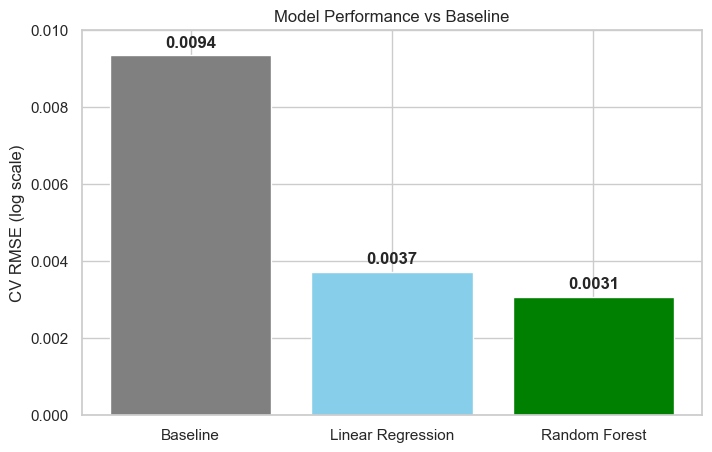

In [44]:
import matplotlib.pyplot as plt

# RMSE values
rmse_values = {
    'Baseline': 0.00935,
    'Linear Regression': 0.00372,
    'Random Forest': 0.00307
}

# Plot
plt.figure(figsize=(8,5))
plt.bar(rmse_values.keys(), rmse_values.values(), color=['gray', 'skyblue', 'green'])
plt.ylabel("CV RMSE (log scale)")
plt.title("Model Performance vs Baseline")
plt.ylim(0, 0.01)
for i, v in enumerate(rmse_values.values()):
    plt.text(i, v + 0.0002, f"{v:.4f}", ha='center', fontweight='bold')
plt.show()


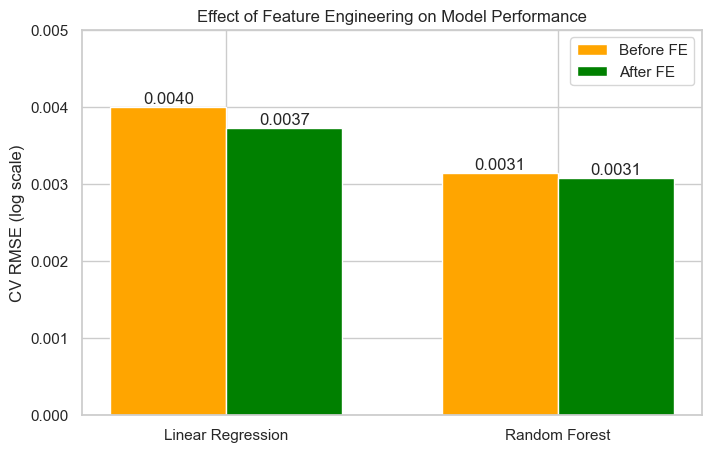

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# RMSE values before and after feature engineering
rmse_before = [0.0040, 0.00314]  # [Linear Regression, Random Forest]
rmse_after = [0.00372, 0.00307]

models = ['Linear Regression', 'Random Forest']
x = np.arange(len(models))

plt.figure(figsize=(8,5))
width = 0.35

# Bars
plt.bar(x - width/2, rmse_before, width, label='Before FE', color='orange')
plt.bar(x + width/2, rmse_after, width, label='After FE', color='green')

# Labels and title
plt.ylabel("CV RMSE (log scale)")
plt.title("Effect of Feature Engineering on Model Performance")
plt.xticks(x, models)
plt.ylim(0, 0.005)
plt.legend()

# Annotate values
for i in range(len(models)):
    plt.text(i - width/2, rmse_before[i] + 0.00005, f"{rmse_before[i]:.4f}", ha='center')
    plt.text(i + width/2, rmse_after[i] + 0.00005, f"{rmse_after[i]:.4f}", ha='center')

plt.show()
